In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pymatgen
import pandas as pd
from pymatgen.ext.matproj import MPRester

In [3]:
from pymatgen.io.vasp.outputs import BandStructure
#clean data (pull data from mats proj, organize into df "query", upload the external csv file too)
my_API = 'nGQPNuLGJu4DXPzhhDShQeeB7nVDHBSd'
with MPRester(my_API) as mpr:
  docs = mpr.summary.search(num_elements = 2,exclude_elements = ["Np","Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm", "Md", "No", "Lr", "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds", "Rg", "Cn", "Nh", "Fl", "Mc", "Lv", "Ts", "Og"],
  is_stable=True,
  fields=["material_id", "band_gap", "formation_energy_per_atom",  "density_atomic", "formula_pretty", "bandstructure"])

df={'formula':[],'density_atomic':[],'band_gap':[],'material_id':[], 'formation_energy_per_atom':[], 'bandstructure':[]}
for doc in docs:
      df['formula'].append(doc.formula_pretty)
      df['density_atomic'].append(doc.density_atomic)
      df['band_gap'].append(doc.band_gap)
      df['material_id'].append(doc.material_id)
      df['formation_energy_per_atom'].append(doc.formation_energy_per_atom)
      df['bandstructure'].append(doc.bandstructure)
mp_query = pd.DataFrame(df)
mp_query.dropna(subset=['bandstructure'], inplace=True)
mp_query.info()

/usr/local/lib/python3.10/dist-packages/mp_api/client/mprester.py:182: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


Retrieving SummaryDoc documents:   0%|          | 0/5149 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3921 entries, 2 to 5148
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   formula                    3921 non-null   object 
 1   density_atomic             3921 non-null   float64
 2   band_gap                   3921 non-null   float64
 3   material_id                3921 non-null   object 
 4   formation_energy_per_atom  3921 non-null   float64
 5   bandstructure              3921 non-null   object 
dtypes: float64(3), object(3)
memory usage: 214.4+ KB


from data pulled from the materials project database, there were 3921 binary compounds with bandstructure data available.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

#calculating z scores to clean the data
data = mp_query.iloc[:, 4]
z_scores = np.abs((data - np.mean(data)) / np.std(data))
threshold = 3 #99.7% confidence interval/data within 3 stds
outlier_mask = np.abs(z_scores) > threshold
clean_data = mp_query[~outlier_mask]
clean_data = clean_data.copy()
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3840 entries, 2 to 5148
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   formula                    3840 non-null   object 
 1   density_atomic             3840 non-null   float64
 2   band_gap                   3840 non-null   float64
 3   material_id                3840 non-null   object 
 4   formation_energy_per_atom  3840 non-null   float64
 5   bandstructure              3840 non-null   object 
dtypes: float64(3), object(3)
memory usage: 210.0+ KB


In [5]:
unique=clean_data["formula"].astype("string").unique() #unique compositions matches with the amount of data cleaned, so no pulled repeats
n = len(unique)
print('there are', n, 'unique chemical compounds')

there are 3840 unique chemical compounds


Reducing the data a bit using a z-score threshold of 3 to only analyze data within 3 standard deviations to the average formation energy per atom values. Reduced the total amount of data to 3840 unique datasets.

In [6]:
clean_data.iloc[1:2, :] #seeing what a row of the data looks like

,formula,density_atomic,band_gap,material_id,formation_energy_per_atom,bandstructure
4,GdB6,9.856148,0.0,mp-22266,-0.45662,setyawan_curtarolo=BandStructureSummaryData(ta...


In [7]:
#create new features (some of my laptop keys aren't working so if my notes seem kind of off, that's why...)
#i'm guessing this new feature is an avg atomic radius, pulling radius from the csv file
from pymatgen.core import Composition

pt = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/periodic_table_final.csv') #pt=periodic table
pt.set_index("Symbol", inplace=True)
avg_radius = []
avg_neg = []
avg_mass = []
for formula in clean_data["formula"]:
  comp=Composition(formula)
  sym = [element.symbol for element in comp.elements]
  rad1 = pt.loc[sym[0]]["AtomicRadius"]
  rad2 = pt.loc[sym[1]]["AtomicRadius"]
  neg1 = pt.loc[sym[0]]["Electronegativity"]
  neg2 = pt.loc[sym[1]]["Electronegativity"]
  mass1 = pt.loc[sym[1]]["AtomicMass"]
  mass2 = pt.loc[sym[1]]["AtomicMass"]
  frac = comp.get_atomic_fraction(sym[0])
  avg_rad = (rad1*frac)+(rad2*(1-frac))
  avg_electro = (neg1*frac)+(neg2*(1-frac))
  avg_m = (mass1*frac)+(mass2*(1-frac))
  avg_radius.append(avg_rad)
  avg_neg.append(avg_electro)
  avg_mass.append(avg_m)

#print(avg_radius) #just checking a few values to see if it matches up, can delete after verification


# can also do more composition averaged data like atomic mass, melting and boiling point,
# for the next portion, need some features that assist with determining the formation energy per atom
# formation energy per atom = [E_comp - sum(E_elements)]/n
# variable n is the number of atoms (working with only binary compounds so M_aX_b), hence n=a+b
# obtain variable n by using
# a_frac = comp.get_atomic_fraction(sym[0]) this is the fraction of M, so inverse is the total number of M in the atom
# n = (1/a_frac)+(1/(1-a_frac))

n_of_atoms = []
for formula in clean_data["formula"]:
  comp=Composition(formula)
  sym = [element.symbol for element in comp.elements]
  frac_a = comp.get_atomic_fraction(sym[0])
  n = (1/frac_a)+(1/(1-frac_a))
  n_of_atoms.append(n)

#it is at this point i realize I probably thought of this assignment incorrectly... oops ahaha oh well i already made the feature
#not actually calculating formation energy per atom.... teehee

clean_data["avg_radius"]=avg_radius
clean_data["avg_neg"]=avg_neg
clean_data["avg_mass"]=avg_mass
clean_data["n_of_atoms"]=n_of_atoms
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3840 entries, 2 to 5148
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   formula                    3840 non-null   object 
 1   density_atomic             3840 non-null   float64
 2   band_gap                   3840 non-null   float64
 3   material_id                3840 non-null   object 
 4   formation_energy_per_atom  3840 non-null   float64
 5   bandstructure              3840 non-null   object 
 6   avg_radius                 3840 non-null   float64
 7   avg_neg                    3840 non-null   float64
 8   avg_mass                   3840 non-null   float64
 9   n_of_atoms                 3840 non-null   float64
dtypes: float64(7), object(3)
memory usage: 330.0+ KB


added some new average values based on the material composition (average mass, radius, and electrogenativity) as well as calculated the number of atoms in each binary compound (because I misinterpreted what was supposed to happen in the regression model. Otherwise, this feature is unnecessary).

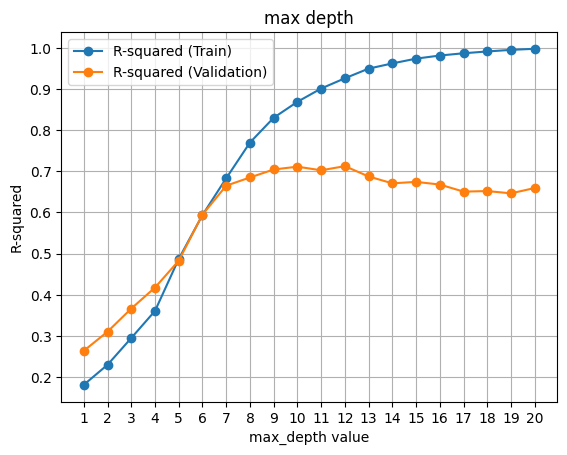

In [126]:
#Regression model. Train several regression models (he says about 3-5) of your choice to predict
#“formation_energy_per_atom” based on information retrieved from MP and designed
#composition-average features. You can use models that we have learned in the class or explore
#other models available in sklearn library.

from sklearn.model_selection import train_test_split

#splitting into training data (60%), validation data (20%), and test data (20%).
X=clean_data.iloc[:, 6:9]
y=clean_data.iloc[:, 4]
X_re, X_test, y_re, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #test=20%, train+val=80%
X_train, X_val, y_train, y_val = train_test_split(X_re, y_re, test_size=0.25, random_state=42) #20/80=1/4

#first model - decision tree
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

max_depth_values = np.arange(1, 21)
r2_train_values = []
r2_val_values = []
for max_depth in max_depth_values:
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree.fit(X_train, y_train)
    y_train_pred = tree.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)
    y_val_pred = tree.predict(X_val)
    r2_val = r2_score(y_val, y_val_pred)
    r2_train_values.append(r2_train)
    r2_val_values.append(r2_val)

plt.plot(max_depth_values, r2_train_values, 'o-', label='R-squared (Train)')
plt.plot(max_depth_values, r2_val_values, 'o-', label='R-squared (Validation)')

plt.xlabel('max_depth value')
plt.ylabel('R-squared')

plt.title('max depth')
plt.xticks(max_depth_values)
plt.grid(True)
plt.legend()
plt.show()

Using the R-squared vs max depth value plot above, the best depth value can be determined to be at the peak of the validation R-squared values.

Mean Squared Error VALIDATION: 0.09937341940603095
R-squared VALIDATION: 0.7209224108877581
Mean Squared Error TESTING: 0.12456114092469735
R-squared TESTING: 0.6631106929714046


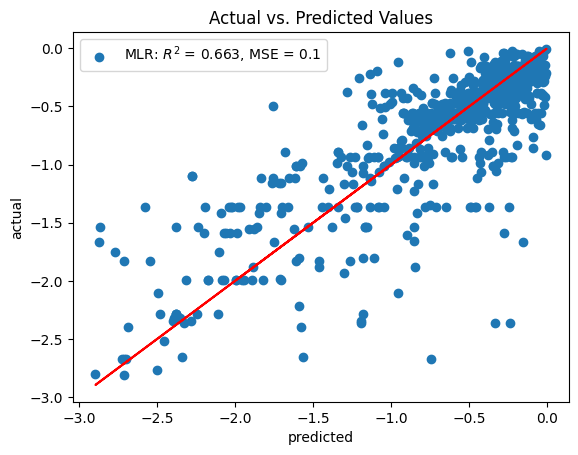

In [127]:
#Based on the training and validation data, the best depth value is 10
besttree = DecisionTreeRegressor(max_depth=10)
besttree.fit(X_train, y_train)
y_pred = besttree.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print("Mean Squared Error VALIDATION:", mse)
print("R-squared VALIDATION:", r2)

y_pred = besttree.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error TESTING:", mse)
print("R-squared TESTING:", r2)

label = "MLR: $R^2$ = %.3f, MSE = %.1f" % (r2, mse)
plt.scatter(y_test, y_pred, label=label)
plt.plot(y_test, y_test,color='r')
plt.xlabel("predicted")
plt.ylabel("actual")
plt.legend()
plt.title("Actual vs. Predicted Values")
plt.show()

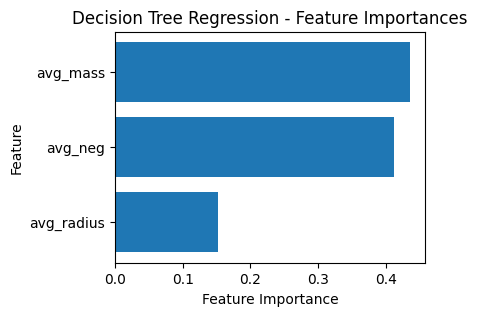

In [128]:
feature_importances = besttree.feature_importances_
feature_names = X.columns
sorted_indices = feature_importances.argsort()

plt.figure(figsize=(4, 3))
plt.barh(range(len(feature_importances)), feature_importances[sorted_indices], align="center")
plt.yticks(range(len(feature_importances)), feature_names[sorted_indices])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Decision Tree Regression - Feature Importances")
plt.show()

Based on the R2 value of about 0.625, it can be inferred from this model that the energy of formation energy per atom is somewhat directly dependent on the average radius, average mass, and average electronegativity of the compound. By looking at the feature importance, average negativity and  average mass have a higher impact on the formation energy per atom than average radius. Logically, an element's electronegativity represents its ability to attract electrons to itself. This plays a large role in the formation of ionic bonds, as these bonds are formed from electron exchange. In addition, the average mass of the compound affects the formation energy due to its relation with the molar mass of each element in the compound. The total number of moles affects the total amount of atoms in each element, thus impacting the formation energy per atom. It must be noted, however, that other factors such as atom arrangement/the most stable structure (ex FCC), atomic packing factor, and lattice energy also play a role in formation energy.

Beyond the formation energy of a compound, the formation energy of a material can also depend on the conditions it was processed in, such as temperature, pressure, etc.

Now let's look at this data through another model: Random Forest. Using the same method as the decision tree, the best hyperparameters for the number of trees (n_estimators) and the max depth are determined first to find the best hyperparameters.

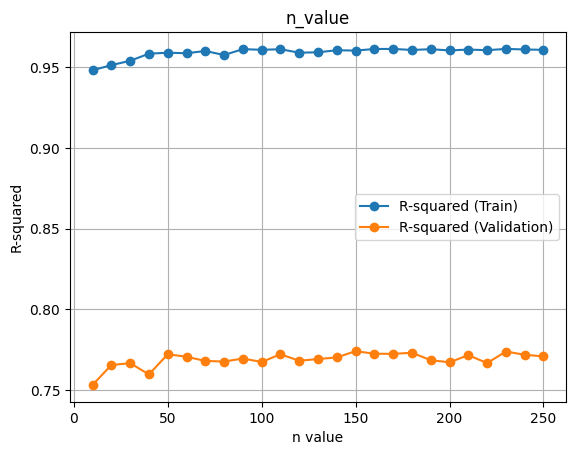

the best n value is [150]


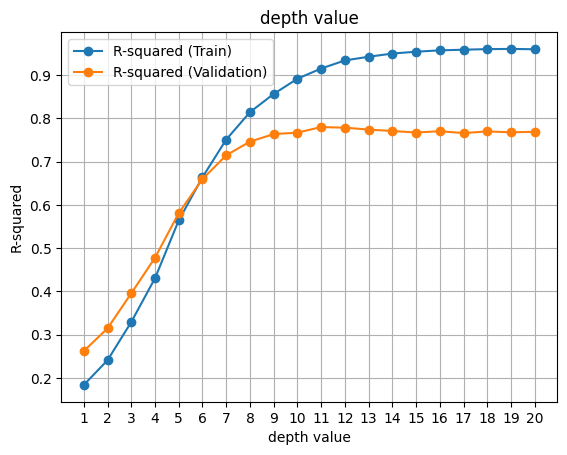

the best depth is [11]
Mean Squared Error TESTING: 0.08417127953025409
R-squared TESTING: 0.7723495158911543


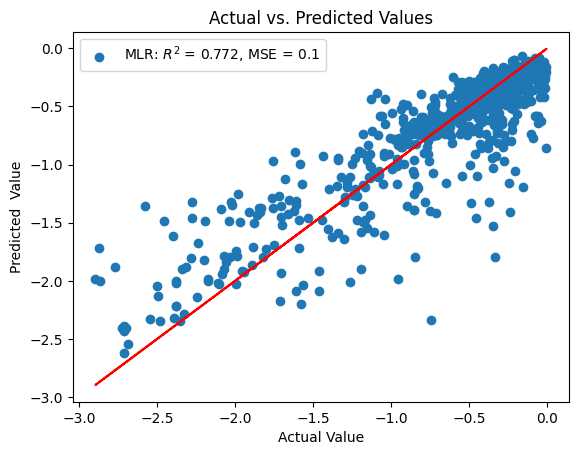

In [130]:
from sklearn.ensemble import RandomForestRegressor

#determining the best number of trees
n_estimator = np.arange(10, 251, 10)
r2_train_values = []
r2_val_values = []
for n_estimate in n_estimator:
    forest = RandomForestRegressor(n_estimators=n_estimate)
    forest.fit(X_train, y_train)
    y_train_pred = forest.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)
    y_val_pred = forest.predict(X_val)
    r2_val = r2_score(y_val, y_val_pred)
    r2_train_values.append(r2_train)
    r2_val_values.append(r2_val)

plt.plot(n_estimator, r2_train_values, 'o-', label='R-squared (Train)')
plt.plot(n_estimator, r2_val_values, 'o-', label='R-squared (Validation)')
plt.xlabel('n value')
plt.ylabel('R-squared')
plt.title('n_value')
plt.grid(True)
plt.legend()
plt.show()
n_compiled = list(zip(n_estimator, r2_val_values))
best_r2 = max(r2_val_values)
best_n = [pair[0] for pair in n_compiled if pair[1] == best_r2]
print('the best n value is', best_n)

#determining the max depth hyperparameter
max_depth_values = np.arange(1, 21)
r2_train_values = []
r2_val_values = []
for max_depth in max_depth_values:
    forest = RandomForestRegressor(max_depth=max_depth, n_estimators=best_n[0])
    forest.fit(X_train, y_train)
    y_train_pred = forest.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)
    y_val_pred = forest.predict(X_val)
    r2_val = r2_score(y_val, y_val_pred)
    r2_train_values.append(r2_train)
    r2_val_values.append(r2_val)

plt.plot(max_depth_values, r2_train_values, 'o-', label='R-squared (Train)')
plt.plot(max_depth_values, r2_val_values, 'o-', label='R-squared (Validation)')
plt.xlabel('depth value')
plt.ylabel('R-squared')
plt.title('depth value')
plt.xticks(max_depth_values)
plt.grid(True)
plt.legend()
plt.show()
depth = list(zip(max_depth_values, r2_val_values))
best_r2 = max(r2_val_values)
best_depth = [pair[0] for pair in depth if pair[1] == best_r2]
print('the best depth is', best_depth)

#making the random forest based on these values
bestforest = RandomForestRegressor(max_depth=best_depth[0], n_estimators=best_n[0])
bestforest.fit(X_train, y_train)

y_pred = bestforest.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error TESTING:", mse)
print("R-squared TESTING:", r2)

label = "MLR: $R^2$ = %.3f, MSE = %.1f" % (r2, mse)
plt.scatter(y_test, y_pred, label=label)
plt.plot(y_test, y_test,color='r')
plt.xlabel("Actual Value")
plt.ylabel("Predicted  Value")
plt.legend()
plt.title("Actual vs. Predicted Values")
plt.show()

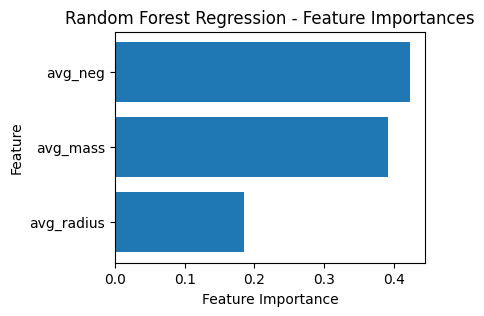

In [131]:
feature_importances = bestforest.feature_importances_
sorted_indices = feature_importances.argsort()

plt.figure(figsize=(4, 3))
plt.barh(range(len(feature_importances)), feature_importances[sorted_indices], align="center")
plt.yticks(range(len(feature_importances)), feature_names[sorted_indices])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Regression - Feature Importances")
plt.show()

Based on these results, we can see the importance of each feature in both the random tree and random forest is about the same. One difference is the accuracy, or R2 value, is higher in the random forest, and this is due to the weakness of random trees. Random trees have difficulty in predicting values outside/beyond their model. Random forests can handle extrapolation since these models can analyze more underlying relationships and complex patterns by aggregating the results of multiple random trees.

In [67]:
#Classification model. Define band_gap < 0.001 as metallic (0) and band_gap >= 0.001 as
#nonmetallic (1), and train classification models to predict the metallicity of binary compounds.
#Note: It is forbidden to use ‘band_gap’ and ‘is_metal’ fields as features in this task!
#Optimize the performance of your models (e.g., tune hyperparameters and/or perform regularization) using the best practices discussed in class.
#Compare the performance of several regression and classification models using the same testing set.

#misunderstood this part so redo time - add in some missing info to get band structure
#adding a new feature a bit late
#pulling the band gap data by pulling all the bandstructure data from the materials database using the material_id as an index
from pymatgen.ext.matproj import Structure

class_data = clean_data.drop('band_gap', axis=1)
num_rows = len(class_data) // 80 #cutting down the original df since it would take too long to run over 3800 samples, this took 6 mins, so everything would take 8 hrs
class_data = class_data.sample(n=num_rows, random_state=42).copy()

band_gaps = []


mpr = MPRester(my_API)
for material_id in class_data['material_id']:
    band_structure = mpr.get_bandstructure_by_material_id(material_id)
    band_gap = band_structure.get_band_gap()["energy"]
    band_gaps.append(band_gap)

class_data['calc_band_gap'] = band_gaps
class_data.info()

/usr/local/lib/python3.10/dist-packages/mp_api/client/mprester.py:182: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 1006 to 4909
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   formula                    48 non-null     object 
 1   density_atomic             48 non-null     float64
 2   material_id                48 non-null     object 
 3   formation_energy_per_atom  48 non-null     float64
 4   bandstructure              48 non-null     object 
 5   avg_radius                 48 non-null     float64
 6   avg_neg                    48 non-null     float64
 7   avg_mass                   48 non-null     float64
 8   n_of_atoms                 48 non-null     float64
 9   calc_band_gap              48 non-null     float64
dtypes: float64(7), object(3)
memory usage: 4.1+ KB


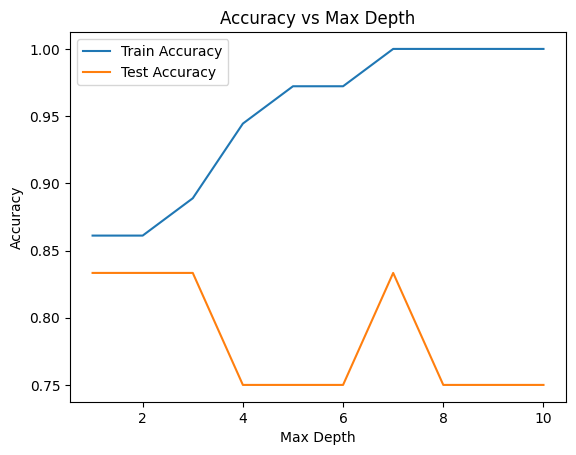

In [102]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
import matplotlib.pyplot as plt

class_data['metallicity'] = -1 #placeholder vals
class_data.loc[class_data['calc_band_gap'] < 0.001, 'metallicity'] = 0
class_data.loc[class_data['calc_band_gap'] >= 0.001, 'metallicity'] = 1
class_data['metallicity'] = class_data['metallicity'].astype('category')

X=class_data.iloc[:, 5:8]
y=class_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

max_depth_values = np.arange(1, 11)
train_accuracy = []
test_accuracy = []

for max_depth in max_depth_values:
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

plt.plot(max_depth_values, train_accuracy, label='Train Accuracy')
plt.plot(max_depth_values, test_accuracy, label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth')
plt.legend()
plt.show()


the accuracy of the trained data is 0.8888888888888888
the accuracy of the test data is 0.8333333333333334


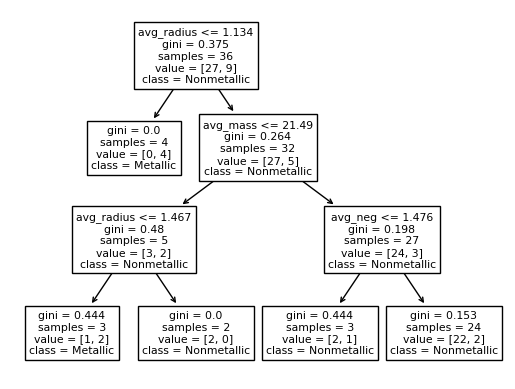

In [124]:

class_tree = DecisionTreeClassifier(max_depth=3)
class_tree.fit(X_train, y_train)
y_train_pred = class_tree.predict(X_train)
y_test_pred = class_tree.predict(X_test)
print('the accuracy of the trained data is', accuracy_score(y_train, y_train_pred))
print('the accuracy of the test data is', accuracy_score(y_test, y_test_pred))
tree.plot_tree(class_tree, feature_names=X.columns, class_names=['Nonmetallic', 'Metallic'])
plt.show()

Accuracy: 0.75


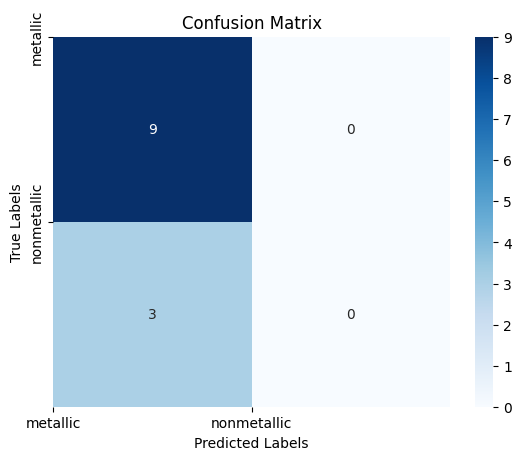

In [122]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


model = LogisticRegression()
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
labels = ["metallic", "nonmetallic"]
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
tick_marks = np.arange(2)
plt.xticks(tick_marks, labels, ha="center")
plt.yticks(tick_marks, labels, va="center")
plt.title('Confusion Matrix')
plt.show()

Based on the confusion matrix, the linear regression model had an accuracy of 75%, where 3 materials that were nonmetallic were predicted to be metallic by the model. On the other hand, the decision tree classifier had an 83% accuracy in predicting whether a material was metallic or nonmetallic based on the average radius, mass, and electronegativity.